# *SDS_Benchmark*: Landsat vs Sentinel-2

(Work in progress)

Here we compare the accuracy of the SDS derived from Landsat and Sentinel-2 for CoastSat, SHOREX and CASSIE (the other algorithms do not use S2).

When running this notebook, the plots showing the comparisons and reporting the accuracy metrics are saved under **/evaluation/Landsat_vs_S2**. You can visualise each individual transect under **/evaluation/Landsat_vs_S2/transects**.

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec
import colorcet as cc
from matplotlib.cm import get_cmap
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
import string
# import utils module located in the repository (utils.py)
import utils
plt.ion()
letters = string.ascii_lowercase

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt','CALAMILLOR']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
    for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

# filepaths to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission','team_Deltares','team_UQMAO']]
submissions = [submissions[_] for _ in [1,2,0]]
print('\nSubmitted shorelines: %s'%submissions)
labels = {'team_CoastSat':'CoastSat',
          'team_SHOREX':'SHOREX',
          'team_Deltares':'ShorelineMonitor',
          'team_CASSIE':'CASSIE',
          'team_UQMAO':'HighTide-SDS',}

# folder where to save all the figures and outputs
fp_eval =  os.path.join(os.getcwd(),'evaluation')
if not os.path.exists(fp_eval): os.makedirs(fp_eval)

# select contour
contour = 'MSL'
groundtruth_type = 'groundtruth_%s'%contour
print(contour)


Benchmark datasets available:
['DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}

Submitted shorelines: ['team_CoastSat', 'team_SHOREX', 'team_CASSIE']
MSL


#### Load Landsat time-series

In [2]:
#%%  create file with Landsat outputs
sub_output = {}
# folder to store evaluation outputs
fp_eval_contour =  os.path.join(fp_eval,'Landsat_vs_S2_%s'%contour)
if not os.path.exists(fp_eval_contour): os.makedirs(fp_eval_contour)
# create a file with Landsat outputs
fn_output = os.path.join(fp_eval_contour,'submissions_Landsat_%s.pkl'%contour)
if os.path.exists(fn_output):
    # load submissions
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)    
    print('Loaded formatted dict...') 
else:
    # loop through submissions
    for sub in submissions:
        print('\n'+sub)
        # get filepaths
        submission_folder = os.path.join(fp_submissions,sub)
        submission_sites = os.listdir(submission_folder)
        sub_output[sub] = {}
        # loop through sites
        for sitename in names_datasets:
            # skip site if it wasn't mapped
            if sitename not in submission_sites: continue
            sub_output[sub][sitename] = {}
            # locate submitted time-series'
            if sub in ['team_CoastSat','team_SHOREX','team_CASSIE']:
                fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries_%s'%contour)
                date_str = 'dates'
                chain_str = 'key'
            else:
                raise Exception('add elif statement for this submission')
            # get the transects mapped
            fn_transects = os.listdir(fp_timeseries)
            for i,fn in enumerate(fn_transects):
                fp = os.path.join(fp_timeseries,fn)
                # get transect name from filename
                key = fn.split('_')[0]
                key = key.split('.csv')[0]
                # read csv files
                df = pd.read_csv(fp,sep=',',parse_dates=[date_str])
                # read chainages
                if chain_str == 'key': 
                    chainage = np.array(df[key])
                else: chainage = np.array(df[chain_str])
                # read dates
                dates_sat = [_.to_pydatetime() for _ in df[date_str]]
                if dates_sat[0].tzinfo is None or dates_sat[0].tzinfo.utcoffset(dates_sat[0]) is None:
                    dates_sat = [pytz.utc.localize(_.to_pydatetime()) for _ in df[date_str]]
                # add satellite name
                satname = list(df['satname'])
                # remove nans
                idx_nan = np.isnan(chainage)
                dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
                satname_nonan = [satname[_] for _ in np.where(~idx_nan)[0]]
                chainage = chainage[~idx_nan]
                # store in sub_output
                sub_output[sub][sitename][key] = {'dates':dates_nonan,
                                                  'chainage':chainage,
                                                  'satname':satname_nonan}
            print('%s -> %d transects'%(sitename,len(sub_output[sub][sitename])))

    # add grountruth to dict
    print('\n'+groundtruth_type)
    sub_output[groundtruth_type] = {}
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        # load groundtruth
        data_folder = os.path.join(fp_datasets,sitename)
        with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
            gt = pickle.load(f) 
        sub_output[groundtruth_type][sitename] = {}
        transects = list(gt.keys())
        for i,tr in enumerate(transects):
            sub_output[groundtruth_type][sitename][tr] =  {'dates':gt[tr]['dates'],
                                                           'chainage':gt[tr]['chainages']}    
        print('%s -> %d transects'%(sitename,len(sub_output[groundtruth_type][sitename])))

    # remove S2 shorelines from SHOREX as it contains both Landsat and S2
    for sitename in sub_output['team_SHOREX'].keys():
        for transect in sub_output['team_SHOREX'][sitename].keys():
            satname = sub_output['team_SHOREX'][sitename][transect]['satname']
            idx_noS2 = [not _ == 'S2' for _ in satname]
            sub_output['team_SHOREX'][sitename][transect]['chainage'] = sub_output['team_SHOREX'][sitename][transect]['chainage'][idx_noS2]
            sub_output['team_SHOREX'][sitename][transect]['dates'] = [sub_output['team_SHOREX'][sitename][transect]['dates'][_] for _ in np.where(idx_noS2)[0]]
            sub_output['team_SHOREX'][sitename][transect]['satname'] = [sub_output['team_SHOREX'][sitename][transect]['satname'][_] for _ in np.where(idx_noS2)[0]]
    print('Removed S2 for SHOREX')   

    # save dictionary in a pickle file
    with open(fn_output,'wb') as f:
        pickle.dump(sub_output,f)
    print('\nGenerated formatted dict for Landsat %s...'%contour)


team_CoastSat
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_SHOREX
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_CASSIE
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

groundtruth_MSL
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 156 transects
Removed S2 for SHOREX

Generated formatted dict for Landsat MSL...


#### Load Sentinel-2 time-series

In [3]:
sub_output = {}
fn_output = os.path.join(fp_eval_contour,'submissions_S2_%s.pkl'%contour)
if os.path.exists(fn_output):
    # load submissions
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)    
    print('Loaded formatted dict...') 
else:
    # loop through submissions
    for sub in submissions:
        print('\n'+sub)
        # get filepaths
        submission_folder = os.path.join(fp_submissions,sub)
        submission_sites = os.listdir(submission_folder)
        sub_output[sub] = {}
        # loop through sites
        for sitename in names_datasets:
            # skip site if it wasn't mapped
            if sitename not in submission_sites: continue
            sub_output[sub][sitename] = {}
            # locate submitted time-series
            if sub in ['team_SHOREX']:
                fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries_%s'%contour)
                date_str = 'dates'
                chain_str = 'key'
            elif sub in ['team_CoastSat','team_CASSIE']:
                fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries_%s_S2'%contour)
                date_str = 'dates'
                chain_str = 'key'
            else:
                raise Exception('add elif statement for this submission')
            # get the transects mapped
            fn_transects = os.listdir(fp_timeseries)
            for i,fn in enumerate(fn_transects):
                fp = os.path.join(fp_timeseries,fn)
                # get transect name from filename
                key = fn.split('_')[0]
                key = key.split('.csv')[0]
                # read csv file and extract dates and chainages
                df = pd.read_csv(fp,sep=',',parse_dates=[date_str])
                # read chainages
                if chain_str == 'key': 
                    chainage = np.array(df[key])
                else: chainage = np.array(df[chain_str])
                # read dates
                dates_sat = [_.to_pydatetime() for _ in df[date_str]]
                if dates_sat[0].tzinfo is None or dates_sat[0].tzinfo.utcoffset(dates_sat[0]) is None:
                    dates_sat = [pytz.utc.localize(_.to_pydatetime()) for _ in df[date_str]]
                # add satellite name
                if sub in ['team_CASSIE']:
                    satname = ['S2' for _ in range(len(dates_sat))]
                else:
                    satname = list(df['satname'])
                # remove nans
                idx_nan = np.isnan(chainage)
                dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
                satname_nonan = [satname[_] for _ in np.where(~idx_nan)[0]]
                chainage = chainage[~idx_nan]
                # store in sub_output
                sub_output[sub][sitename][key] = {'dates':dates_nonan,
                                                  'chainage':chainage,
                                                  'satname':satname_nonan}
            print('%s -> %d transects'%(sitename,len(sub_output[sub][sitename])))

    # add grountruth to dict
    print('\n'+groundtruth_type)
    sub_output[groundtruth_type] = {}
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        # load groundtruth
        data_folder = os.path.join(fp_datasets,sitename)
        with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
            gt = pickle.load(f) 
        sub_output[groundtruth_type][sitename] = {}
        transects = list(gt.keys())
        for i,tr in enumerate(transects):
            sub_output[groundtruth_type][sitename][tr] =  {'dates':gt[tr]['dates'],
                                                           'chainage':gt[tr]['chainages']}    
        print('%s -> %d transects'%(sitename,len(sub_output[groundtruth_type][sitename])))

    # remove Landsat shorelines from SHOREX as it contains both Landsat and S2
    for sitename in sub_output['team_SHOREX'].keys():
        for transect in sub_output['team_SHOREX'][sitename].keys():
            satname = sub_output['team_SHOREX'][sitename][transect]['satname']
            idx_S2 = [_ == 'S2' for _ in satname]
            sub_output['team_SHOREX'][sitename][transect]['chainage'] = sub_output['team_SHOREX'][sitename][transect]['chainage'][idx_S2]
            sub_output['team_SHOREX'][sitename][transect]['dates'] = [sub_output['team_SHOREX'][sitename][transect]['dates'][_] for _ in np.where(idx_S2)[0]]
            sub_output['team_SHOREX'][sitename][transect]['satname'] = [sub_output['team_SHOREX'][sitename][transect]['satname'][_] for _ in np.where(idx_S2)[0]]
    print('Removed Landsat for SHOREX')   

    # save dictionary in a pickle file
    with open(fn_output,'wb') as f:
        pickle.dump(sub_output,f)
    print('\nGenerated formatted dict for Sentinel-2 %s...'%contour) 


team_CoastSat
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_SHOREX
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_CASSIE
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

groundtruth_MSL
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 156 transects
Removed Landsat for SHOREX

Generated formatted dict for Sentinel-2 MSL...


#### Compute horizontal errors

In [4]:
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }

fn_output = os.path.join(fp_eval_contour,'submissions_Landsat_%s.pkl'%contour)
with open(fn_output,'rb') as f:
    sub_output = pickle.load(f)

# check if file exists
fn_errors = os.path.join(fp_eval_contour,'errors_Landsat_%s.pkl'%contour)
if os.path.exists(fn_errors):
    # load output_eval pickle    
    with open(fn_errors,'rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...')    
else:
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[groundtruth_type][sitename]
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            fp_save = os.path.join(fp_eval_contour,'transects',sitename,sub)
            if not os.path.exists(fp_save): os.makedirs(fp_save)
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            chain_sat_all_dm, chain_sur_all_dm = [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries2(sub_output[sub][sitename][key],gt,key,settings)
                _.savefig(os.path.join(fp_save,'%s.jpg'%key))
                plt.close(_)
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames
                # add demeaned time-series for calculating R2
                chain_sat_all_dm = np.append(chain_sat_all_dm,ts_sat-np.nanmean(ts_sat))
                chain_sur_all_dm = np.append(chain_sur_all_dm,ts_sur-np.nanmean(ts_sur))
            
            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all,
                                          'chain_sat_dm':chain_sat_all_dm,
                                          'chain_gt_dm':chain_sur_all_dm}
            
            # calculate statistics for site
            chain_error = chain_sat_all - chain_sur_all
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all_dm, chain_sat_all_dm)
            R2 = rvalue**2
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)
            
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            output_eval[sitename][sub]['RMSE'] = rmse
            output_eval[sitename][sub]['Mean'] = mean
            output_eval[sitename][sub]['STD'] = std
            output_eval[sitename][sub]['q90'] = q90
    
    # save output_eval as pickle    
    with open(fn_errors,'wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict Landsat %s...'%contour)   
    
fn_output = os.path.join(fp_eval_contour,'submissions_S2_%s.pkl'%contour)
with open(fn_output,'rb') as f:
    sub_output = pickle.load(f)
# check if file exists
fn_errors = os.path.join(fp_eval_contour,'errors_S2_%s.pkl'%contour)
if os.path.exists(fn_errors):
    # load output_eval pickle    
    with open(fn_errors,'rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...')    
else:
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[groundtruth_type][sitename]
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            fp_save = os.path.join(fp_eval_contour,'transects',sitename,sub)
            if not os.path.exists(fp_save): os.makedirs(fp_save)
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            chain_sat_all_dm, chain_sur_all_dm = [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries2(sub_output[sub][sitename][key],gt,key,settings)
                _.savefig(os.path.join(fp_save,'%s_S2.jpg'%key))
                plt.close(_)
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames
                # add demeaned time-series for calculating R2
                chain_sat_all_dm = np.append(chain_sat_all_dm,ts_sat-np.nanmean(ts_sat))
                chain_sur_all_dm = np.append(chain_sur_all_dm,ts_sur-np.nanmean(ts_sur))
            
            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all,
                                          'chain_sat_dm':chain_sat_all_dm,
                                          'chain_gt_dm':chain_sur_all_dm}
            
            # calculate statistics for site
            chain_error = chain_sat_all - chain_sur_all
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all_dm, chain_sat_all_dm)
            R2 = rvalue**2
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)
            
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            output_eval[sitename][sub]['RMSE'] = rmse
            output_eval[sitename][sub]['Mean'] = mean
            output_eval[sitename][sub]['STD'] = std
            output_eval[sitename][sub]['q90'] = q90
    
    # save output_eval as pickle    
    with open(fn_errors,'wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict Sentinel-2 %s...'%contour)   

Generated errors dict Landsat MSL...
Generated errors dict Sentinel-2 MSL...


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

#### Combine Landsat and Sentinel-2 outputs and error metrics

In [5]:
# Load Landsat
fn_output = os.path.join(fp_eval_contour,'submissions_Landsat_%s.pkl'%contour)
fn_errors = os.path.join(fp_eval_contour,'errors_Landsat_%s.pkl'%contour)
with open(fn_output,'rb') as f:
    sub_output_L = pickle.load(f)
with open(fn_errors,'rb') as f:
    output_eval_L = pickle.load(f) 
# Load S2    
fn_output = os.path.join(fp_eval_contour,'submissions_S2_%s.pkl'%contour)
fn_errors = os.path.join(fp_eval_contour,'errors_S2_%s.pkl'%contour)
with open(fn_output,'rb') as f:
    sub_output_S2 = pickle.load(f)
with open(fn_errors,'rb') as f:
    output_eval_S2 = pickle.load(f)  
    
# colorpalette to use for each submission
cmap = get_cmap("cet_glasbey_dark")
# colours = plt.get_cmap('Dark2').colors
colours = cmap(np.arange(10))
colours = colours[[0,1,3]]
# limits of yaxis in shoreline plots
ylims = np.array([-50,50])

#### Accuracy Assessment Landsat vs Sentinel-2

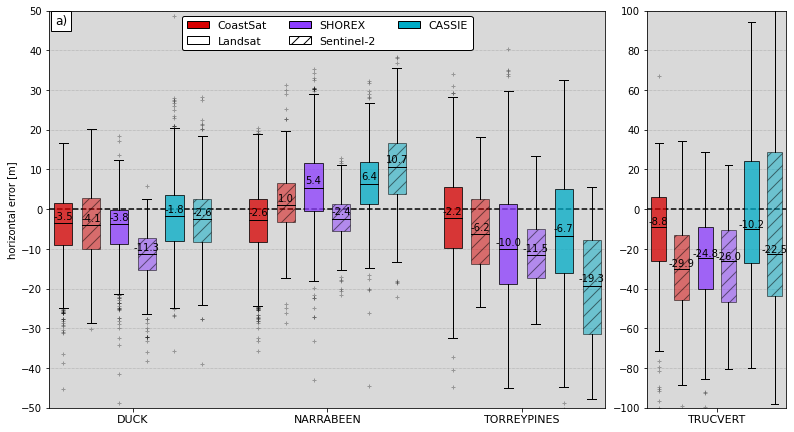

In [6]:
# plot boxplots
factor = 7
# make plot comparing the time-series
fig = plt.figure(figsize=[11.5,6.2], tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylabel='horizontal error [m]', ylim=[-50,50]);
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        for l,sat in enumerate(['Landsat','Sentinel-2']):
            if sat == 'Landsat': 
                output_eval = output_eval_L
                hatch = ''
                alpha = 0.75
            else:                
                output_eval = output_eval_S2
                hatch = '//'
                alpha = 0.5
            # compute errors
            chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
            # plot boxplot
            bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k*2+l],
                            widths=0.65,patch_artist=True,showfliers=True,
                            whiskerprops={'linewidth':1},
                            flierprops={'alpha':0.3,'markersize':4,
                                        'color':'0.5'})
            for median in bp['medians']:
                median.set(color='k', linewidth=1)
            for j,boxes in enumerate(bp['boxes']):
                boxes.set(facecolor=colours[k],alpha=alpha,hatch=hatch)
            # add median value as text
            ax.text((i)*factor+k*2+l,np.median(chain_error)+1,
                    '%.1f'%np.median(chain_error),
                    horizontalalignment='center', fontsize=10)
# add legend
handles = []
handles.append(mpatches.Patch(color=colours[0],ec='k',label=labels[submissions[0]]))
handles.append(mpatches.Patch(color='None',ec='k',label='Landsat'))
handles.append(mpatches.Patch(color=colours[1],ec='k',label=labels[submissions[1]]))
handles.append(mpatches.Patch(color='None',ec='k',label='Sentinel-2',hatch='//'))
handles.append(mpatches.Patch(color=colours[2],ec='k',label=labels[submissions[2]]))
ax1.legend(handles=handles, loc='upper center', ncol=3, fontsize=11,edgecolor='k',framealpha=1);
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets)-1)],labels=names_datasets[:-1]);
ax1.set_xticklabels(names_datasets[:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [3]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# add letters
ax1.text(0.01,0.99, letters[0] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax1.transAxes, fontsize=12,zorder=10)
# save figure
fig.savefig(os.path.join(fp_eval_contour,'3_boxplots_selected.jpg'),dpi=500)

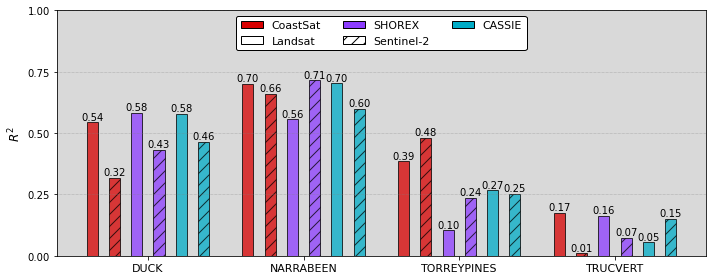

In [7]:
# plot R2
fig,ax = plt.subplots(1,1,figsize=[10,4], tight_layout=True)
ax.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax.set_facecolor('0.85')
ax.set( ylim=[0,1]);
ax.set_ylabel(r'$R^2$',fontsize=12)
# ax.text(0.005,0.98, letters[1] + ')', 
#         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
#         ha='left',va='top', transform=ax3.transAxes, fontsize=14,zorder=10)
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions):
        for l,sat in enumerate(['Landsat','Sentinel-2']):
            if sat == 'Landsat': 
                output_eval = output_eval_L
                hatch = ''
                alpha = 0.75
            else:                
                output_eval = output_eval_S2
                hatch = '//'
                alpha = 0.5
            # compute errors
            ax.bar((i)*factor+k*2+l,output_eval[sitename][sub]['R2'],ec='k',fc=colours[k],width=0.5,alpha=0.75,hatch=hatch)
            # add median value as text
            ax.text((i)*factor+k*2+l,output_eval[sitename][sub]['R2']+0.01,
                    '%.2f'%output_eval[sitename][sub]['R2'],
                    horizontalalignment='center', fontsize=10)
# set xticklabels
ax.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets))],labels=names_datasets);
ax.set_xticklabels(names_datasets,fontweight='normal',fontsize=11);
# set yticklabels
ax.set_yticks(np.arange(0,1+0.25,0.25));
# add legend
handles = []
handles.append(mpatches.Patch(color=colours[0],ec='k',label=labels[submissions[0]]))
handles.append(mpatches.Patch(color='None',ec='k',label='Landsat'))
handles.append(mpatches.Patch(color=colours[1],ec='k',label=labels[submissions[1]]))
handles.append(mpatches.Patch(color='None',ec='k',label='Sentinel-2',hatch='//'))
handles.append(mpatches.Patch(color=colours[2],ec='k',label=labels[submissions[2]]))
ax.legend(handles=handles, loc='upper center', ncol=3, fontsize=11,edgecolor='k',framealpha=1);
fig.savefig(os.path.join(fp_eval_contour,'3_R2_selected.jpg'),dpi=500)

#### Plot histograms

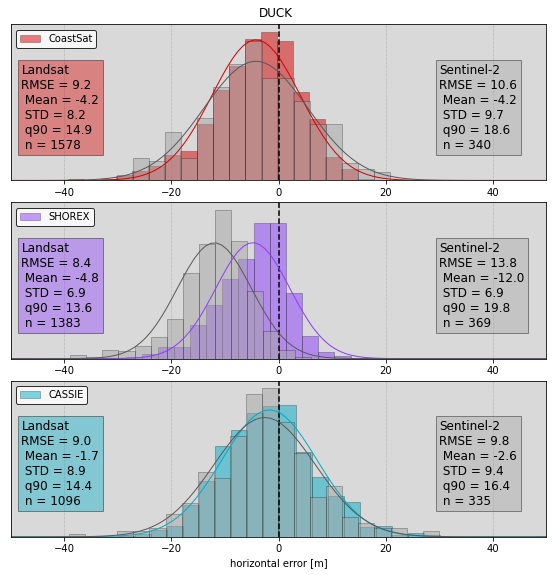

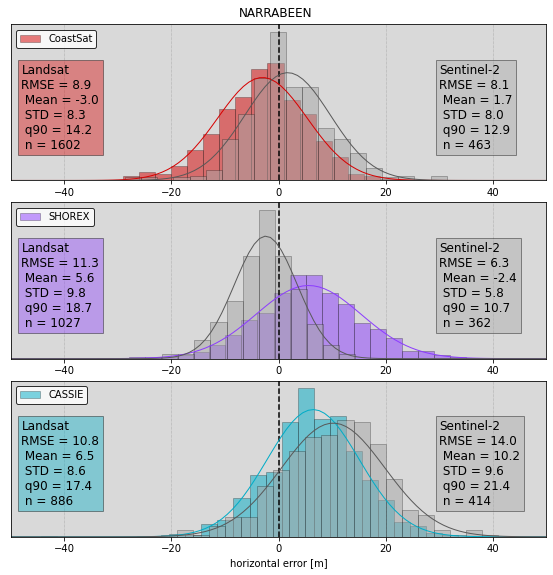

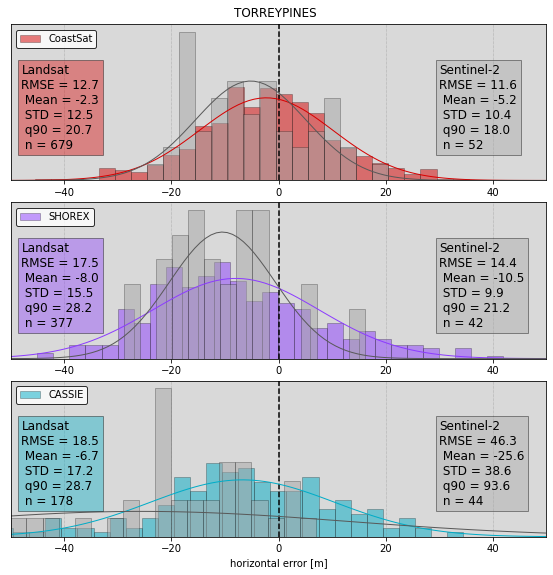

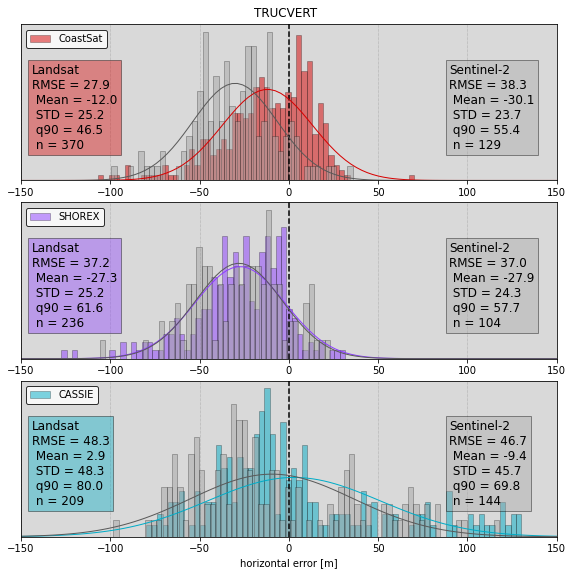

In [8]:
# loop through sites
for sitename in names_datasets:
    # make plot comparing the time-series
    fig = plt.figure(figsize=[8,8], tight_layout=True)
    gs = gridspec.GridSpec(len(submissions),1)
    gs.update(left=0.04, right=0.97, bottom=0.06, top=0.95, hspace=0.14)
    fig.suptitle('%s'%(sitename),fontsize=12)
    if sitename == 'TRUCVERT': 
        xlims = [-150,150]
        binwidth = 10
    else:
        xlims = settings['lims']
        binwidth = settings['binwidth']
    # loop through submissions
    for k,sub in enumerate(submissions):
        ax = fig.add_subplot(gs[k,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0) 
        ax.axvline(x=0, ls='--', lw=1.5, color='k')
        binwidth = settings['binwidth']
        ax.set_yticks([])
        ax.set_facecolor('0.85')
        ax.set(xlabel='horizontal error [m]', xlim=xlims)
        for l,sat in enumerate(['Landsat','Sentinel-2']):
            if sat == 'Landsat': 
                output_eval = output_eval_L
                xtext = 0.02
                color = colours[k]
            else:                
                output_eval = output_eval_S2
                xtext = 0.8
                color = '0.65'
            chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
            # get metrics
            R2 = output_eval[sitename][sub]['R2']
            rmse = output_eval[sitename][sub]['RMSE']
            mean = output_eval[sitename][sub]['Mean']
            std = output_eval[sitename][sub]['STD']
            q90 = output_eval[sitename][sub]['q90']  
            # plot histogram
            bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
            density = ax.hist(chain_error, bins=bins, density=True, color=color,
                              edgecolor='k',lw=0.5, alpha=0.5, label=labels[sub])
            mu, std = stats.norm.fit(chain_error)
            pval = stats.normaltest(chain_error)[1]
            x = np.linspace(xlims[0], xlims[1], 100)
            p = stats.norm.pdf(x, mu, std)
            if sat == 'Sentinel-2':
                ax.plot(x, p, '-',color='0.35', linewidth=1)
            else:
                ax.plot(x, p, '-',color=color, linewidth=1)
            str_stats = '%s\nRMSE = %.1f\n Mean = %.1f\n STD = %.1f\n q90 = %.1f\n n = %d' % (sat,rmse, mean, std, q90, len(chain_error))
            ax.text(xtext, 0.75, str_stats,va='top', transform=ax.transAxes,fontsize=12,
                    bbox=dict(boxstyle="square", ec='k',fc=color,alpha=0.4))
            if sat == 'Landsat':
                ax.legend(loc=[0.01,0.85],edgecolor='k')

    fig.savefig(os.path.join(fp_eval_contour,'2_%s_histograms.jpg'%sitename),dpi=500)
